## Transformer for OCR


In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q datasets jiwer

This notebook is mostly taken from the TrOCR guide of hugging face

## Prepare data


In [1]:
import pandas as pd

# df = pd.read_fwf('/home/rufael.marew/Documents/Academics/ML701/project/transformer-ocr/dataset/train_iam_lines.txt',header=None)
df_train = pd.read_csv('./dataset/train_iam_lines.txt', sep="\t", header=None)
df_test = pd.read_csv('./dataset/test_iam_lines.txt', sep="\t", header=None)
df_train.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df_test.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# del df[2]
# some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df_train.head()

,file_name,text
0,/home/rufael.marew/Documents/Academics/ML701/p...,"crochet hooks range in size from number 3/0,"
1,/home/rufael.marew/Documents/Academics/ML701/p...,than 500 people - 167 of them members of
2,/home/rufael.marew/Documents/Academics/ML701/p...,Sentence Database
3,/home/rufael.marew/Documents/Academics/ML701/p...,had their eyes on a seagoing boat.
4,/home/rufael.marew/Documents/Academics/ML701/p...,tried to show that the balance-sheet must


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [2]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
# # we reset the indices to start from zero
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [4]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='',
                           df=df_train,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='',
                           df=df_test,
                           processor=processor)

2022-12-07 10:35:33.336500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 10:35:33.504593: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-07 10:35:33.541212: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-07 10:35:34.652346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 12017
Number of validation examples: 1336


Let's verify an example from the training dataset:

In [6]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

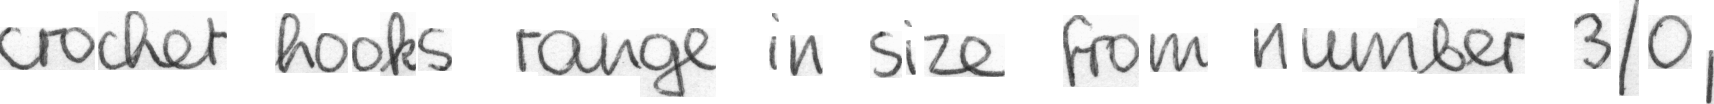

In [7]:
image = Image.open(df_train['file_name'][0]).convert("RGB")
image

## Train a model with randomly initialized weights

Here, we initialize the TrOCR model Randomly.

In [8]:
from transformers import (
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    BeitConfig,
    ViTConfig,
    ViTModel,
    BeitModel,
    VisionEncoderDecoderModel
)
from transformers import AutoTokenizer, AutoModelForCausalLM

encoder = ViTModel(ViTConfig(image_size=384))
decoder = TrOCRForCausalLM(TrOCRConfig())

model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [9]:
sum(p.numel() for p in model.parameters())

341028352

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [10]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
# training arguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="./checkpoints/random_trocr/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=20
)

In [8]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_285122/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [9]:
def compute_metrics(pred):
    '''
        input
            pred: tuple
                (the predictions by the model, the actual ground-truth labels)
            
        return 
            result: dictionary
                {'metric': result}
            
    '''
    result={}
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    result['cer'] = cer_metric.compute(predictions=pred_str, references=label_str)

    return result

In [14]:

from transformers import default_data_collator
import time
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
start=time.time()
trainer.train()
print("training time: ",time.time()-start)

Using cuda_amp half precision backend
/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12017
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15040
  Number of trainable parameters = 341028352


Step,Training Loss,Validation Loss,Cer
200,6.371900,6.220143,0.822255
400,6.041100,5.962493,0.783023
600,5.948300,5.789368,0.772738
800,5.244600,5.684603,0.750688
1000,5.259800,5.578206,0.777925
1200,5.208700,5.488376,0.766776
1400,5.605400,5.437445,0.767288
1600,5.122500,5.355769,0.743032
1800,5.181800,5.306367,0.752822
2000,5.474600,5.253785,0.961367


***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
Saving model checkpoint to ./checkpoints/random_trocr/checkpoint-1000
Configuration saved in ./checkpoints/random_trocr/checkpoint-1000/config.json
Model weights saved in ./checkpoints/random_trocr/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./checkpoints/random_trocr/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  N

***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
Saving model checkpoint to ./checkpoints/random_trocr/checkpoint-13000
Configuration saved in ./checkpoints/random_trocr/checkpoint-13000/config.json
Model weights saved in ./checkpoints/random_trocr/checkpoint-13000/pytorch_model.bin
Feature extractor saved in ./checkpoints/random_trocr/checkpoint-13000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 16
***** Running Evaluation *****

training time:  18991.587956666946


### Train model with pre-trained weights
Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage.

In [10]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./checkpoints/pre-trained_trocr/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=20,
    learning_rate = 5e-5,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments


from transformers import default_data_collator
import time
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
start=time.time()
trainer.train()
print("training time: ",time.time()-start)

Using cuda_amp half precision backend
/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12017
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30060
  Number of trainable parameters = 384864768


Step,Training Loss,Validation Loss,Cer
200,2.052300,2.574864,0.495025
400,2.718700,1.928053,0.272156
600,2.188500,2.112221,0.374559
800,2.024900,1.602539,0.223628
1000,2.181600,1.725378,0.264342
1200,1.539200,1.517027,0.203941
1400,1.808900,1.548576,0.212726
1600,1.224400,1.560083,0.217612
1800,1.382000,1.530685,0.195244
2000,1.556400,1.583961,0.211897


***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
Saving model checkpoint to ./checkpoints/pre-trained_trocr/checkpoint-1000
Configuration saved in ./checkpoints/pre-trained_trocr/checkpoint-1000/config.json
Model weights saved in ./checkpoints/pre-trained_trocr/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./checkpoints/pre-trained_trocr/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1336
  Batch size = 8
***** Running Evaluatio

In [14]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="./checkpoints",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=20,
    learning_rate = 5e-5,
)

from transformers import default_data_collator
import time
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
start=time.time()
trainer.train()
print("training time: ",time.time()-start)

Using cuda_amp half precision backend
/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2332
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2920
  Number of trainable parameters = 384864768


Step,Training Loss,Validation Loss,Cer
200,1.055800,1.348095,0.185420
400,0.548200,1.261035,0.156463
600,0.499000,1.336517,0.163284
800,0.619800,1.230956,0.150786
1000,0.442000,1.157444,0.142618
1200,0.335000,1.217389,0.150623
1400,0.225100,1.172042,0.141842
1600,0.287800,1.255675,0.138615
1800,0.200400,1.126264,0.131468
2000,0.172800,1.064816,0.117950


***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
Saving model checkpoint to ./checkpoints/checkpoint-1000
Configuration saved in ./checkpoints/checkpoint-1000/config.json
Model weights saved in ./checkpoints/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./checkpoints/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
***** Running Evaluation *****
  Num examples = 583
  Batch size = 16
Saving model checkpoint t

training time:  4076.830145597458


In [17]:
model.encoder.save_pretrained("./checkpoints/pre-trained/final_encoder")
model.decoder.save_pretrained("./checkpoints/pre-trained/final_decoder")

Configuration saved in ./encoder_2/config.json
Model weights saved in ./encoder_2/pytorch_model.bin
Configuration saved in ./decoder_2/config.json
Model weights saved in ./decoder_2/pytorch_model.bin


## Inference


In [14]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
model_inf = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("./checkpoints/pre-trained/final_encoder",
                                                                      "./checkpoints/pre-trained/final_decoder")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-stage1')

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [15]:
import requests
from PIL import Image
import os
test = os.listdir('./test_images')

text = {}
for i in test:
    url = os.path.join("./test_images",i)
    image = Image.open(url).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model_inf.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    text[i] = generated_text
text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/rufael.marew/.conda/envs/trocr_hug/lib/python3.10/site-packages/transformers/generation_utils.py:1357: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token i

{'d07-100-08.png': 'itself was quoted, almost as if it were a',
 'test_3.jpeg': 'The quick brown fox.',
 'test_5.jpeg': 'Wewanna submit our report today',
 'r06-041-06.png': 'and had the air of being written by an',
 'test_4.jpeg': '2 The atmospheric temperature',
 'h07-044a-05.png': 'compositions must look to recoup the'}